# ОИАД. Лабораторная работа №2

### Загрузка датасета

In [1]:
import pandas as pd

df = pd.read_csv('../../datasets/students_simple.csv')
df.head()

,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5


### Выбор столбцов

In [2]:
print(f'N1 = {3 % 5}')
print(f'N2 = {3 % 5 + 5}')

N1 = 3
N2 = 8


In [3]:
data = df[['income', 'work_exp']]
data.head()

,income,work_exp
0,430,26
1,640,63
2,610,94
3,330,16
4,420,49


## 1. Расчет корреляций

### 1. Фехнера

#### Формула коэффициента корреляции Фехнера

##### Общий вид:

$$
r_F = \frac{N_c - N_d}{N_c + N_d}
$$

где:
- $r_F$ - коэффициент корреляции Фехнера
- $N_c$ - количество совпадающих знаков отклонений от среднего
- $N_d$ - количество несовпадающих знаков отклонений от среднего

In [4]:
import numpy as np

def fechner_correlation(df, col1='income', col2='work_exp'):
    x = df[col1].values
    y = df[col2].values
    
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    signs_x = np.sign(x - mean_x)
    signs_y = np.sign(y - mean_y)
    
    matches = np.sum(signs_x == signs_y)
    mismatches = np.sum(signs_x != signs_y)
    
    fechner_coef = (matches - mismatches) / (matches + mismatches)
    
    return fechner_coef

In [5]:
print(f'Корреляция Фехнера: {fechner_correlation(data)}')

Корреляция Фехнера: 0.6


Вывод: умеренная положительная связь между переменными

### 2. Пирсона + доверительный интервал

In [6]:
import math

def pearson_correlation(df, col1='income', col2='work_exp'):
    x = df[col1].values
    y = df[col2].values
    
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    n = len(x_clean)
    
    mean_x = sum(x_clean) / n
    mean_y = sum(y_clean) / n
    
    covariance = 0.0
    for i in range(n):
        covariance += (x_clean[i] - mean_x) * (y_clean[i] - mean_y)
    covariance = covariance / (n - 1)  
    
    std_x = 0.0
    std_y = 0.0
    
    for i in range(n):
        std_x += (x_clean[i] - mean_x) ** 2
        std_y += (y_clean[i] - mean_y) ** 2
    
    std_x = math.sqrt(std_x / (n - 1))  
    std_y = math.sqrt(std_y / (n - 1))  
    
    if std_x == 0 or std_y == 0:
        correlation = 0.0  
    else:
        correlation = covariance / (std_x * std_y)
    
    return correlation

In [11]:
pearson_corr = pearson_correlation(data)
print(f'Корреляция Пирсона: {pearson_corr:.2f}')

Корреляция Пирсона: 0.77


Вывод: сильная положительная линейная связь между переменными

### Формула расчета доверительного интервала для корреляции Пирсона

#### Алгоритм расчета:

##### 1. Z-преобразование Фишера (преобразование r в z)

$$
z_r = \text{arctanh}(r) = \frac{1}{2} \ln\left(\frac{1 + r}{1 - r}\right)
$$

##### 2. Стандартная ошибка z-преобразования

$$
SE_{z_r} = \frac{1}{\sqrt{n - 3}}
$$

##### 3. Доверительный интервал для z-преобразования

$$
\text{ДИ}_{z_r} = z_r \pm z_{\alpha/2} \times SE_{z_r}
$$

$$
z_{lower} = z_r - z_{\alpha/2} \times SE_{z_r}
$$
$$
z_{upper} = z_r + z_{\alpha/2} \times SE_{z_r}
$$

##### 4. Обратное преобразование к шкале корреляции

$$
r_{lower} = \tanh(z_{lower}) = \frac{e^{2z_{lower}} - 1}{e^{2z_{lower}} + 1}
$$

$$
r_{upper} = \tanh(z_{upper}) = \frac{e^{2z_{upper}} - 1}{e^{2z_{upper}} + 1}
$$

### Итоговая формула доверительного интервала:

$$
\text{ДИ}_r = \left[ \tanh\left( \text{arctanh}(r) - z_{\alpha/2} \cdot \frac{1}{\sqrt{n-3}} \right), \ \tanh\left( \text{arctanh}(r) + z_{\alpha/2} \cdot \frac{1}{\sqrt{n-3}} \right) \right]
$$

### Обозначения:

- $r$ - коэффициент корреляции Пирсона
- $n$ - размер выборки
- $z_{\alpha/2}$ - критическое значение стандартного нормального распределения
- $\text{arctanh}$ - гиперболический арктангенс
- $\tanh$ - гиперболический тангенс

### Критические значения $z_{\alpha/2}$:

- Для 90% ДИ: $z_{0.05} = 1.645$
- Для 95% ДИ: $z_{0.025} = 1.960$
- Для 99% ДИ: $z_{0.005} = 2.576$

In [20]:
from scipy import stats

def pearson_ci_from_r(r, n, confidence=0.95):
    
    zr = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)

    z = stats.norm.ppf(1 - (1 - confidence) / 2)

    ci_low_zr = zr - z * se
    ci_high_zr = zr + z * se

    ci_low = np.tanh(ci_low_zr)
    ci_high = np.tanh(ci_high_zr)

    return (ci_low, ci_high)

In [22]:
ci = pearson_ci_from_r(pearson_corr, len(data))
print(f'Доверительный интервал: [{ci[0]:.2f}, {ci[1]:.2f}]')

Доверительный интервал: [0.49, 0.90]


### 3. Спирмена

### Корреляция Спирмена

#### Основная формула:

$$\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}$$

где:
- $d_i = R(x_i) - R(y_i)$ - разность рангов
- $n$ - количество наблюдений
- $R(x_i)$, $R(y_i)$ - ранги значений

#### С повторяющимися рангами:

$$\rho = \frac{\text{cov}(R_X, R_Y)}{\sigma_{R_X} \sigma_{R_Y}}$$

#### Свойства:
- $\rho \in [-1, 1]$
- Непараметрическая мера монотонной связи
- Устойчива к выбросам

In [23]:
def spearman_correlation_manual(df, col1='income', col2='work_exp'):
    x = df[col1].values
    y = df[col2].values
    
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    n = len(x_clean)
    
    def calculate_ranks(data):
        sorted_indices = np.argsort(data)
        
        ranks = np.zeros(len(data))
        
        for rank, idx in enumerate(sorted_indices):
            ranks[idx] = rank + 1
        
        unique_values, counts = np.unique(data, return_counts=True)
        
        for value, count in zip(unique_values, counts):
            if count > 1:
                indices = np.where(data == value)[0]
                mean_rank = np.mean(ranks[indices])
                ranks[indices] = mean_rank
        
        return ranks
    
    rank_x = calculate_ranks(x_clean)
    rank_y = calculate_ranks(y_clean)
    
    d = rank_x - rank_y
    
    sum_d_squared = np.sum(d ** 2)
    
    if len(np.unique(x_clean)) == n and len(np.unique(y_clean)) == n:
        rho = 1 - (6 * sum_d_squared) / (n * (n ** 2 - 1))
    else:
        mean_rank = (n + 1) / 2
        sum_x_sq = np.sum((rank_x - mean_rank) ** 2)
        sum_y_sq = np.sum((rank_y - mean_rank) ** 2)
        
        rho = 1 - (sum_d_squared) / (2 * (sum_x_sq + sum_y_sq))
    
    return rho

In [25]:
print(f'Корреляция Спирмена: {spearman_correlation_manual(data):.2f}')

Корреляция Спирмена: 0.86


Вывод: сильная монотонная связь между переменными

### 4. Кенделла

### Корреляция Кендалла (τ)

#### Формула τ-b (учитывает связи):

$$\tau_b = \frac{C - D}{\sqrt{(C + D + T_x)(C + D + T_y)}}$$

где:
- $C$ - количество согласованных пар
- $D$ - количество несогласованных пар  
- $T_x$ - количество связей по X
- $T_y$ - количество связей по Y

#### Определение пар:

##### Согласованная пара:
$(x_i - x_j)(y_i - y_j) > 0$  
(оба различия имеют одинаковый знак)

##### Несогласованная пара:
$(x_i - x_j)(y_i - y_j) < 0$  
(различия имеют разные знаки)

##### Связи (ties):
- $x_i = x_j$ - связь по X
- $y_i = y_j$ - связь по Y

#### Свойства:
- $\tau \in [-1, 1]$
- Непараметрическая мера монотонной связи
- Устойчива к выбросам
- Интерпретация: вероятность согласованности минус вероятность несогласованности

In [26]:
def kendall_correlation(df, col1='income', col2='work_exp'):
    x = df[col1].values
    y = df[col2].values
    
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    n = len(x_clean)
    
    concordant = 0  
    discordant = 0 
    tie_x = 0       
    tie_y = 0      
    
    for i in range(n):
        for j in range(i + 1, n):
            dx = x_clean[i] - x_clean[j]
            dy = y_clean[i] - y_clean[j]
            
            if dx * dy > 0:
                concordant += 1
            elif dx * dy < 0:
                discordant += 1
            else:
                if dx == 0 and dy == 0:
                    pass  
                elif dx == 0:
                    tie_x += 1
                elif dy == 0:
                    tie_y += 1
    
    total_pairs = n * (n - 1) / 2
    
    numerator = concordant - discordant
    denominator = np.sqrt((concordant + discordant + tie_x) * (concordant + discordant + tie_y))
    
    if denominator == 0:
        tau = 0.0
    else:
        tau = numerator / denominator
    
    return tau

In [27]:
print(f'Корреляция Кенделла: {kendall_correlation(data):.2f}')

Корреляция Кенделла: 0.63


Вывод: сильная монотонная связь между переменными

## 2. Визуализация
### 1. Гистограммы

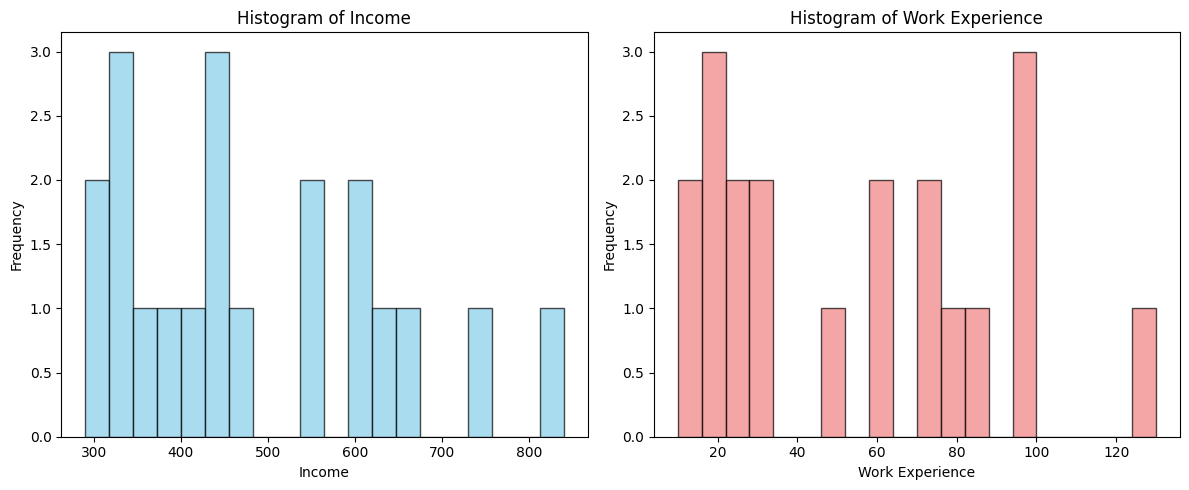

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(df['income'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Income')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Income')

ax2.hist(df['work_exp'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_xlabel('Work Experience')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Work Experience')

plt.tight_layout()
plt.show()

### 2. График рассеяния (scatter plot)

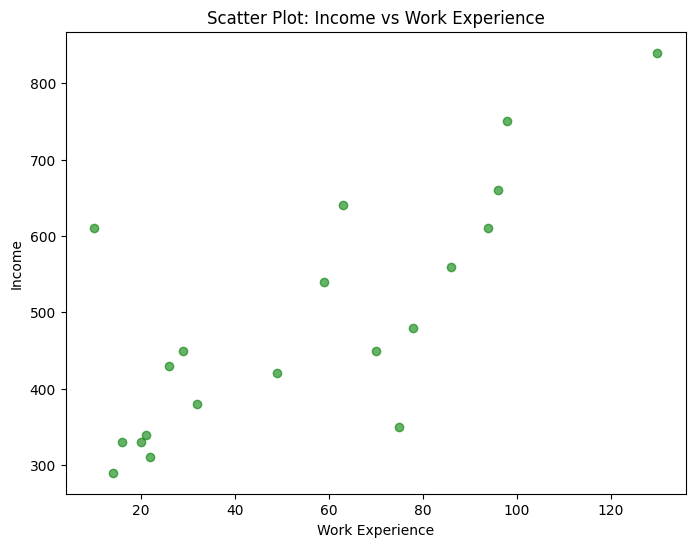

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(df['work_exp'], df['income'], alpha=0.6, color='green')
plt.xlabel('Work Experience')
plt.ylabel('Income')
plt.title('Scatter Plot: Income vs Work Experience')
plt.show()

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. показательная, $y = w_1^x \cdot w_0$

Показать результаты на графиках

#### Будем использовать Метод наименьших квадратов 

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
x = df['work_exp'].values
y = df['income'].values

In [32]:
def calculate_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

### 1. Линейная регрессия: y = w1*x + w0

In [33]:
coef_linear = np.polyfit(x, y, 1)
w1_linear, w0_linear = coef_linear
y_pred_linear = w1_linear * x + w0_linear
error_linear = calculate_error(y, y_pred_linear)

In [42]:
print(f'Error: {error_linear:.2f}')

Error: 9688.21


### Квадратичная регрессия: y = w2*x^2 + w1*x + w0

In [34]:
coef_quad = np.polyfit(x, y, 2)
w2_quad, w1_quad, w0_quad = coef_quad
y_pred_quad = w2_quad * x**2 + w1_quad * x + w0_quad
error_quad = calculate_error(y, y_pred_quad)

In [43]:
print(f'Error: {error_quad:.2f}')

Error: 8101.15


### Гиперболическая регрессия: y = w1/x + w0

In [35]:
x_hyper = 1 / x
coef_hyper = np.polyfit(x_hyper, y, 1)
w1_hyper, w0_hyper = coef_hyper
y_pred_hyper = w1_hyper / x + w0_hyper
error_hyper = calculate_error(y, y_pred_hyper)

In [44]:
print(f'Error: {error_hyper:.2f}')

Error: 18707.27


### 4. Показательная регрессия: y = w1^x * w0
### Линеаризация: ln(y) = x*ln(w1) + ln(w0)

In [36]:
y_log = np.log(y)
coef_exp = np.polyfit(x, y_log, 1)
ln_w1, ln_w0 = coef_exp
w1_exp = np.exp(ln_w1)
w0_exp = np.exp(ln_w0)
y_pred_exp = w0_exp * (w1_exp ** x)
error_exp = calculate_error(y, y_pred_exp)

In [45]:
print(f'Error: {error_exp:.2f}')

Error: 8945.69


### Построение графиков

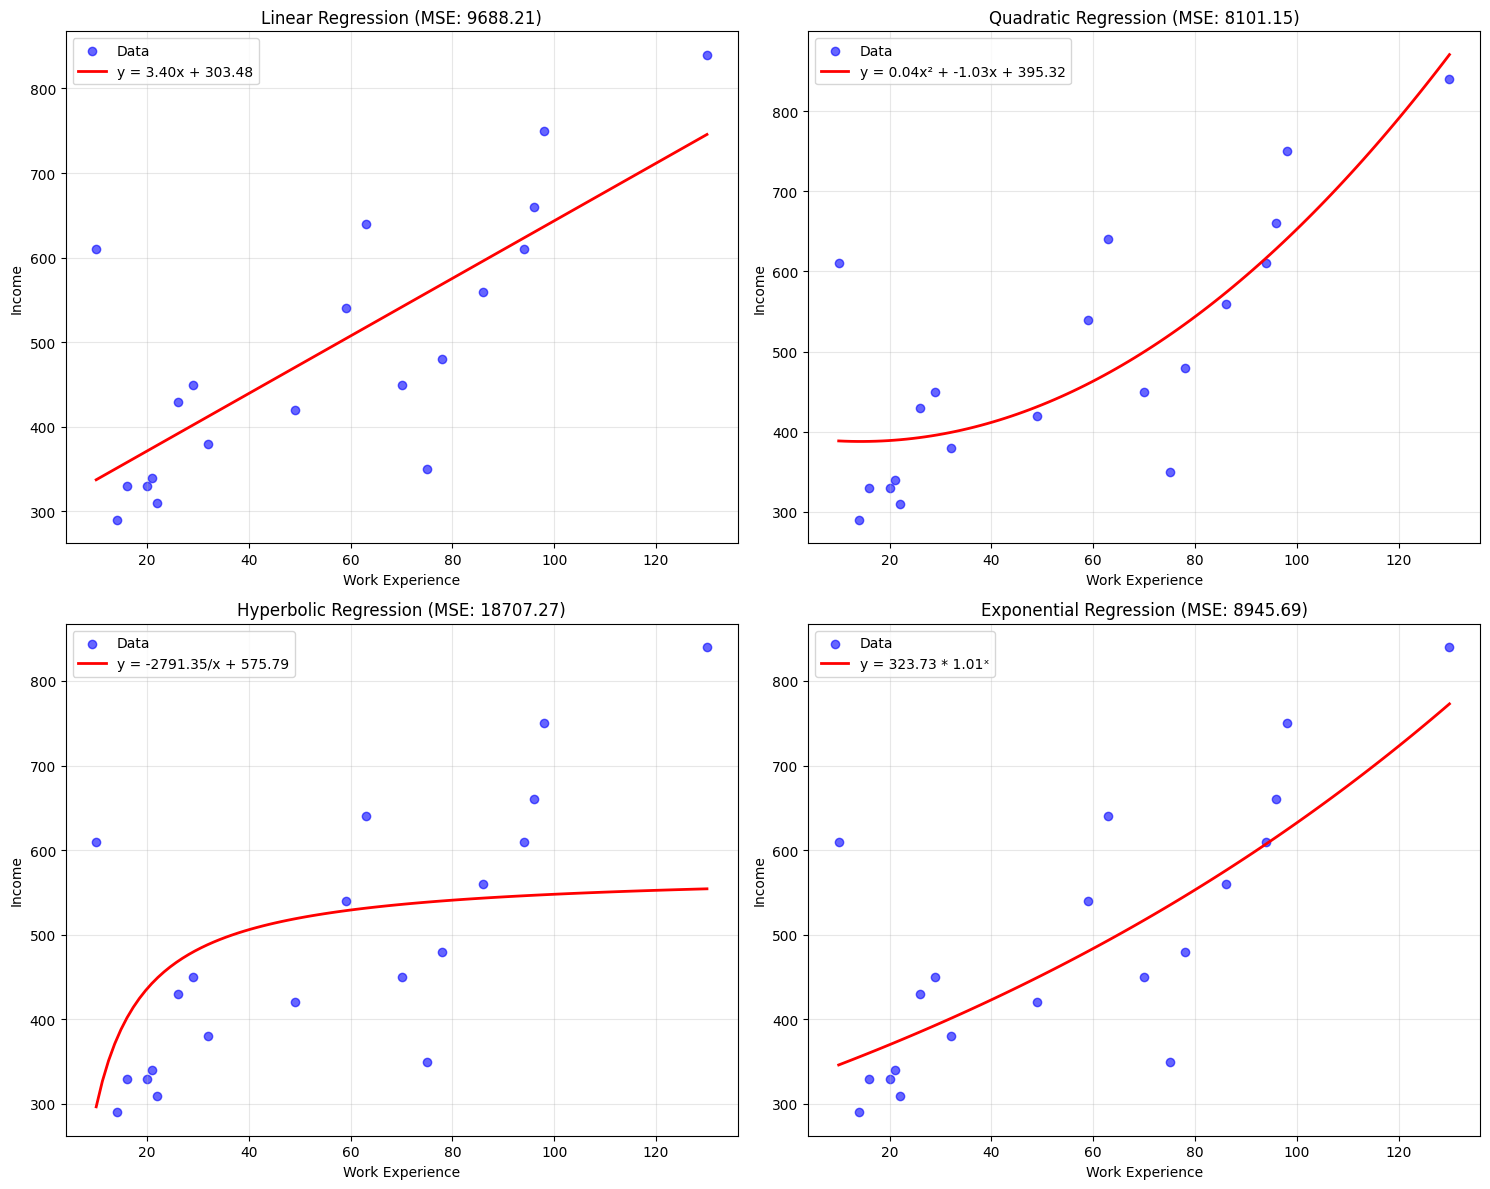

In [39]:
# Построение графиков
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
x_sorted = np.sort(x)
x_range = np.linspace(x.min(), x.max(), 100)

# 1. Линейная регрессия
axes[0,0].scatter(x, y, alpha=0.6, color='blue', label='Data')
axes[0,0].plot(x_sorted, w1_linear * x_sorted + w0_linear, 'r-', linewidth=2, 
               label=f'y = {w1_linear:.2f}x + {w0_linear:.2f}')
axes[0,0].set_xlabel('Work Experience')
axes[0,0].set_ylabel('Income')
axes[0,0].set_title(f'Linear Regression (MSE: {error_linear:.2f})')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Квадратичная регрессия
axes[0,1].scatter(x, y, alpha=0.6, color='blue', label='Data')
axes[0,1].plot(x_range, w2_quad * x_range**2 + w1_quad * x_range + w0_quad, 'r-', linewidth=2,
               label=f'y = {w2_quad:.2f}x² + {w1_quad:.2f}x + {w0_quad:.2f}')
axes[0,1].set_xlabel('Work Experience')
axes[0,1].set_ylabel('Income')
axes[0,1].set_title(f'Quadratic Regression (MSE: {error_quad:.2f})')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Гиперболическая регрессия
axes[1,0].scatter(x, y, alpha=0.6, color='blue', label='Data')
axes[1,0].plot(x_range, w1_hyper / x_range + w0_hyper, 'r-', linewidth=2,
               label=f'y = {w1_hyper:.2f}/x + {w0_hyper:.2f}')
axes[1,0].set_xlabel('Work Experience')
axes[1,0].set_ylabel('Income')
axes[1,0].set_title(f'Hyperbolic Regression (MSE: {error_hyper:.2f})')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Показательная регрессия
axes[1,1].scatter(x, y, alpha=0.6, color='blue', label='Data')
axes[1,1].plot(x_range, w0_exp * (w1_exp ** x_range), 'r-', linewidth=2,
               label=f'y = {w0_exp:.2f} * {w1_exp:.2f}ˣ')
axes[1,1].set_xlabel('Work Experience')
axes[1,1].set_ylabel('Income')
axes[1,1].set_title(f'Exponential Regression (MSE: {error_exp:.2f})')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Вывод: 
Наименьшая ошибка получилась при использовании квадратичной регрессии, наибольшая - при использовании гиперболической.

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера

### Критерий Фишера для сравнения регрессионных моделей

#### Формула F-статистики:

$$
F = \frac{\frac{SSR_{\text{worst}} - SSR_{\text{best}}}{df_{\text{worst}} - df_{\text{best}}}}{\frac{SSR_{\text{best}}}{df_{\text{best}}}}
$$

#### Обозначения:

- $SSR_{\text{best}}$ - сумма квадратов остатков наилучшей модели
- $SSR_{\text{worst}}$ - сумма квадратов остатков наихудшей модели  
- $df_{\text{best}}$ - степени свободы наилучшей модели: $n - k_{\text{best}}$
- $df_{\text{worst}}$ - степени свободы наихудшей модели: $n - k_{\text{worst}}$
- $n$ - количество наблюдений
- $k$ - количество параметров в модели

#### Степени свободы:

- Линейная модель: $k = 2$ параметра ($w_0, w_1$)
- Квадратичная модель: $k = 3$ параметра ($w_0, w_1, w_2$)
- Гиперболическая модель: $k = 2$ параметра ($w_0, w_1$)
- Показательная модель: $k = 2$ параметра ($w_0, w_1$)

#### Нулевая гипотеза:

$H_0$: Модели одинаково хорошо описывают данные

#### Критерий принятия решения:

Если $F > F_{\text{крит}}(\alpha, df_1, df_2)$, то отвергаем $H_0$

где:
- $df_1 = df_{\text{worst}} - df_{\text{best}}$
- $df_2 = df_{\text{best}}$
- $\alpha$ - уровень значимости (обычно 0.05)

In [46]:
import scipy.stats as stats

y_pred_best = y_pred_quad
error_best = error_quad

y_pred_worst = y_pred_hyper
error_worst = error_hyper

def calculate_fisher_test(y_true, y_pred_best, y_pred_worst):
    n = len(y_true)
    
    SSR_best = np.sum((y_true - y_pred_best) ** 2) 
    SSR_worst = np.sum((y_true - y_pred_worst) ** 2) 
    
    df_best = n - 3  # для квадратичной модели (3 параметра)
    df_worst = n - 2  # для гиперболической модели (2 параметра)
    
    # F-статистика
    F_statistic = ((SSR_worst - SSR_best) / (df_worst - df_best)) / (SSR_best / df_best)
    
    # P-value
    p_value = 1 - stats.f.cdf(F_statistic, df_worst - df_best, df_best)
    
    return F_statistic, p_value, SSR_best, SSR_worst

# Расчет F-критерия
F_stat, p_value, SSR_best, SSR_worst = calculate_fisher_test(y, y_pred_best, y_pred_worst)

# Критическое значение F-распределения
alpha = 0.05
df1 = (len(y) - 2) - (len(y) - 3)  
df2 = len(y) - 3  
F_critical = stats.f.ppf(1 - alpha, df1, df2)

print("КРИТЕРИЙ ФИШЕРА: ПРОВЕРКА СООТВЕТСТВИЯ МОДЕЛЕЙ ДАННЫМ")
print("=" * 60)
print(f"Наилучшая модель: Квадратичная регрессия")
print(f"Наихудшая модель: Гиперболическая регрессия")
print(f"Размер выборки: n = {len(y)}")
print()
print(f"Сумма квадратов остатков (SSR) наилучшей модели: {SSR_best:.4f}")
print(f"Сумма квадратов остатков (SSR) наихудшей модели: {SSR_worst:.4f}")
print()
print(f"F-статистика: {F_stat:.4f}")
print(f"Критическое значение F({df1},{df2}) при α={alpha}: {F_critical:.4f}")
print(f"P-value: {p_value:.6f}")
print()

if F_stat > F_critical:
    print("РЕЗУЛЬТАТ: Наилучшая модель СТАТИСТИЧЕСКИ ЗНАЧИМО лучше наихудшей")
    print("           (отвергаем нулевую гипотезу о равенстве качества моделей)")
else:
    print("РЕЗУЛЬТАТ: Наилучшая модель НЕ СТАТИСТИЧЕСКИ ЗНАЧИМО лучше наихудшей")
    print("           (нет оснований отвергать нулевую гипотезу)")

# Сравнение MSE
print("\nСРАВНЕНИЕ ОШИБОК:")
print(f"MSE наилучшей модели: {error_best:.4f}")
print(f"MSE наихудшей модели: {error_worst:.4f}")
print(f"Улучшение: {((error_worst - error_best) / error_worst * 100):.1f}%")

КРИТЕРИЙ ФИШЕРА: ПРОВЕРКА СООТВЕТСТВИЯ МОДЕЛЕЙ ДАННЫМ
Наилучшая модель: Квадратичная регрессия
Наихудшая модель: Гиперболическая регрессия
Размер выборки: n = 20

Сумма квадратов остатков (SSR) наилучшей модели: 162023.0982
Сумма квадратов остатков (SSR) наихудшей модели: 374145.3729

F-статистика: 22.2566
Критическое значение F(1,17) при α=0.05: 4.4513
P-value: 0.000199

РЕЗУЛЬТАТ: Наилучшая модель СТАТИСТИЧЕСКИ ЗНАЧИМО лучше наихудшей
           (отвергаем нулевую гипотезу о равенстве качества моделей)

СРАВНЕНИЕ ОШИБОК:
MSE наилучшей модели: 8101.1549
MSE наихудшей модели: 18707.2686
Улучшение: 56.7%
